In [1]:
!nvidia-smi

Fri Oct 24 13:23:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              8W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Saving pikachu.jpg to pikachu.jpg
Imagen cargada como NumPy array. Forma (H, W, C): 600x678x3


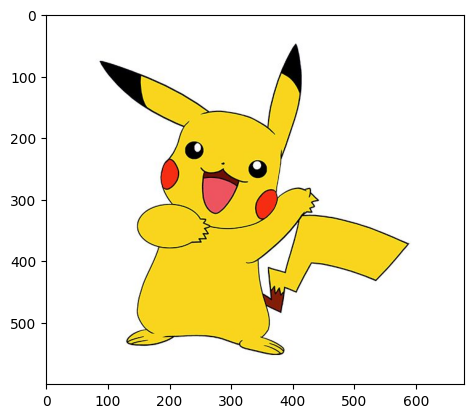

In [3]:
import cv2
import cupy as cp
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

""" Cada pixel de la imagen tendra los 3 colores RGB con rangos de valores [0.0 a 1.0] """

uploaded = files.upload()

img_name = list(uploaded.keys())[0]
img = cv2.imread(img_name)
img_cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_np = img_cv_rgb.astype(np.float32) / 255.0
H, W, C = img_np.shape
print(f"Imagen cargada como NumPy array. Forma (H, W, C): {H}x{W}x{C}")

plt.imshow(img_np)
plt.show()

In [6]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import time

import numpy as np
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 # resuelve bug de versiones

In [10]:
@cuda.jit
def grayscale_kernel_1D(img_color, img_gray):
    """
    Kernel 1D que mapea un índice lineal (idx) a coordenadas 2D (i, j).
    Esto elimina la ambigüedad del orden (Ancho, Alto) del lanzamiento.
    """
    # Obtener el índice lineal del píxel
    idx = cuda.grid(1)

    # Obtener las dimensiones de la imagen de salida
    rows, cols = img_gray.shape
    total_pixels = rows * cols

    # Chequeo de límites (para el índice lineal)
    if idx < total_pixels:
        # Mapeo de índice 1D (idx) a coordenadas 2D (i, j)
        i = idx // cols  # Fila (Alto)
        j = idx % cols   # Columna (Ancho)

        R = img_color[i, j, 0]
        G = img_color[i, j, 1]
        B = img_color[i, j, 2]

        # 3. Cálculo de la intensidad de gris
        gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B

        # 4. Asignar el valor de gris al array de salida
        img_gray[i, j] = gray_value

In [11]:
# --- 3. Procesamiento Acelerado en la GPU (CUDA) ---

# 3.1 Crear arrays de salida en la CPU y transferirlos a la GPU
d_img_color = cuda.to_device(img_np)
img_gray_cpu = np.zeros((H, W), dtype=np.float32)
d_img_gray = cuda.to_device(img_gray_cpu)

# 3.2 Configurar el lanzamiento del kernel (Grid y Block)
THREADS_PER_BLOCK_1D = 256  # Un solo número de hilos por bloque
total_pixels = H * W
BLOCKS_PER_GRID_1D = (total_pixels + THREADS_PER_BLOCK_1D - 1) // THREADS_PER_BLOCK_1D

print(f"Lanzando kernel CUDA con configuración 1D:")
print(f"  Total de píxeles: {total_pixels}")
print(f"  Hilos por bloque: {THREADS_PER_BLOCK_1D}")
print(f"  Bloques por rejilla: {BLOCKS_PER_GRID_1D}")

start_gpu = time.time()
# Lanzamiento del kernel 1D
grayscale_kernel_1D[BLOCKS_PER_GRID_1D, THREADS_PER_BLOCK_1D](d_img_color, d_img_gray)
cuda.synchronize()
time_gpu = time.time() - start_gpu
print(f"Tiempo de ejecución en GPU: {time_gpu:.4f} segundos")

# 3.3 Mover el resultado de la GPU de vuelta a la CPU
img_gray_gpu_result = d_img_gray.copy_to_host()

Lanzando kernel CUDA con configuración 1D:
  Total de píxeles: 406800
  Hilos por bloque: 256
  Bloques por rejilla: 1590
Tiempo de ejecución en GPU: 0.0782 segundos


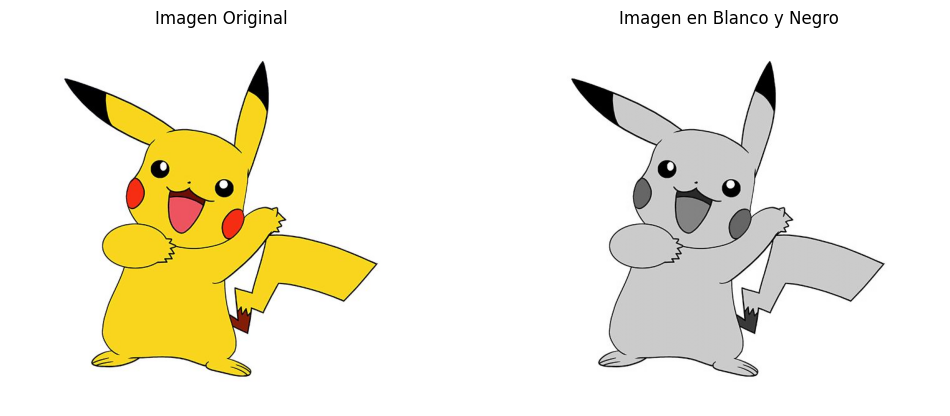

In [12]:
# --- 4. Visualización del Resultado ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_gray_gpu_result, cmap='gray')
plt.title("Imagen en Blanco y Negro")
plt.axis('off')
plt.show()